In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Code to unzip data - Load New Test Collection and Concept Dataset.
!unzip /content/drive/MyDrive/New_Work/Complete_Concept_Dataset.zip -d /content/
!unzip /content/drive/MyDrive/New_Work/Complete_Test_Collection_without_RBR.zip -d /content/
# !unzip /content/drive/MyDrive/ImplicitFeedbackForESADataset/Concept_Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5889.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_589.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5890.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5891.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5892.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5893.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5894.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5895.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5896.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5897.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5898.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_5899.txt  
  inflating: /content/Concept_Dataset/Old_Dataset_Concepts/c_59.txt  
  inflating: /co

In [ ]:
concept_dir_path = "/content/Concept_Dataset"

In [ ]:
!pip install weighted-levenshtein
!pip install git+https://github.com/libindic/indic-trans.git
!pip install bnunicodenormalizer
!pip install indic-nlp-library
!pip install stopwordsiso
!pip install nltk
!pip install -U bnlp_toolkit
!pip install git+https://github.com/riteshpanjwani/pyiwn@master#egg=pyiwn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 33.6 MB/s 
  Created wheel for weighted-levenshtein: filename=weighted_levenshtein-0.2.1-cp37-cp37m-linux_x86_64.whl size=315610 sha256=e75e49792e1271ebef9b066310f62958eb9f21c62c3cf1964b915c34935a73e7
  Stored in directory: /root/.cache/pip/wheels/a1/cd/2e/d1ef8a9e61c14e20842ff10c98eae98a64610ef18bc5fff8fa
Successfully built weighted-levenshtein
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/libindic/indic-trans.git to /tmp/pip-req-build-wmpycsg5
  Running command git clone -q https://github.com/libindic/indic-trans.git /tmp/pip-req-build-wmpycsg5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached pbr-5.10.0-py2.py3-none-any.whl (11

In [ ]:
import stopwordsiso as stopwords
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as eng_stopwords
import stopwordsiso as stopwords
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from bnlp import NLTKTokenizer
import sklearn
import numpy as np
import scipy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


punkt not found. downloading...


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
#@title Code to read ESA Train dataset
tr_docs = []
tr_dids = []
tr_file_paths = []

for dirpath, dirnames, filenames in os.walk("/content/Train_Dataset"):
  for file_name in filenames:
    # Get the absolute file path
    file_path = os.path.join(str(dirpath), str(file_name))
    tr_file_paths.append(file_path)
    # Create a file object.
    fileObject = open(file_path, "r+", encoding='utf-8', errors='ignore')
    # Extract the text from the file.
    text = fileObject.read()
    tr_docs.append(text)
    # using re.findall() we extract all the numbers from the string
    temp = re.findall(r'\d+', file_name)
    tr_doc_num = ''.join(temp)
    tr_dids.append(tr_doc_num)
print("Number of documents in the corpus: ",len(tr_dids))

Number of documents in the corpus:  2000


In [ ]:
#@title Code to read ESA Concept dataset
c_docs = []
c_dids = []
c_file_paths = []
for dirpath, dirnames, filenames in os.walk(concept_dir_path):
  for file_name in filenames:
    # Get the absolute file path
    file_path = os.path.join(str(dirpath), str(file_name))
    c_file_paths.append(file_path)
    # Create a file object.
    fileObject = open(file_path, "r+", encoding='utf-8', errors='ignore')
    # Extract the text from the file.
    text = fileObject.read()
    c_docs.append(text)
    # using re.findall() we extract all the numbers from the string
    temp = re.findall(r'\d+', file_name)
    c_doc_num = ''.join(temp)
    c_dids.append(c_doc_num)

print("Number of documents in the corpus: ",len(c_dids))

Number of documents in the corpus:  9349


In [ ]:
class document_linearization:
	def pre_process(self,input_text):
		"""
		Description: Performs text normalisation, removes punctuations and stop words and returns a list of tokens
		:param input_text:  The text which needs to be cleaned.
		:param stop_words: List of stopwords to be removed from the input text.
		:return: list of tokens
		"""
		stop_words = stopwords.stopwords("bn").union(set(eng_stopwords.words('english')),
                                                     {'একটা', 'তাঁহার', 'দিয়া', 'বলিয়া', 'লইয়া', 'আসিয়া', 'লাগিল',
                                                      'কহিল', 'আসিয়া', 'তাহাকে', 'করিল', 'কহিলেন', 'কোনটি', 'ধরনের',
                                                      'বলিলেন', 'করিত', 'চলিয়া', 'ধরিয়া', 'পড়িয়া', 'করিবার', 'হইত',
                                                      'নহে', 'ফিরিয়া', 'কেহ', 'বলিতে', 'রহিল', 'পড়িল', 'উঠিল',
                                                      'বাহির', 'দেখিয়া', 'উঠিয়া', 'ফিরিয়া', 'অবশেষে', 'কিছুতেই',
                                                      'তেমনি', 'তোমাকে', 'নে', 'মাঝে', 'সকল', 'অত্যন্ত', 'একটু',
                                                      'একেবারে', 'এক', 'একটা', 'একদিন', 'কথা', 'তারই', 'হয়ে', 'হওয়ায়',
                                                      'রয়েছে', 'এমনকি', 'একজন', 'দিয়েছেন', 'একটা', 'হয়নি', 'সাথে',
                                                      'হয়েই', 'দিয়ে', 'কেমনে', 'করিয়ে', 'তোরা', 'জন্যে', 'পেয়ে',
                                                      'পাওয়া', 'তোর', 'ছাড়া', 'ছাড়াও', 'হওয়ার', 'তোমাদের', 'চেয়ে',
                                                      'কথা', 'জানিয়েছে', 'মত', 'অর্থাৎ', 'গিয়েছে', 'জাানিয়ে', 'হয়েছে',
                                                      'হিসেবে', 'হওয়া', 'এলো', 'করায়', 'তাঁহারা', 'দেওয়ার', 'হইয়া',
                                                      'হয়েছেন', 'তোদের', 'অর্ধভাগে', 'তিনই', 'এসো', 'দেয়', 'এক', 'যায়',
                                                      'দিয়েছে', 'চায়', 'হয়েছিল', 'তুই', 'হয়তো', 'হৈতে', 'অনুযায়ী',
                                                      'কয়েকটি', 'পাঁচ', 'করিয়া', 'সময়', 'থাকায়'})

		# Perform text normalisation
		# Reference: https://nbviewer.jupyter.org/url/anoopkunchukuttan.github.io/indic_nlp_library/doc/indic_nlp_examples.ipynb#Text-Normalization
		factory = IndicNormalizerFactory()
		normalizer = factory.get_normalizer("bn", remove_nuktas=False)
		output_text=normalizer.normalize(input_text)

		# Remove punctuation from the text.
		text = output_text.strip()
		text = text.replace("’", "")
		text = text.replace("‘", "")
		text = text.replace('”', "")
		text = text.replace("“", "")

		# Some of the punctuation symbols were obtained from here: https://github.com/paul-pias/Text-Preprocessing-in-Bangla-and-English
		clean_text = re.sub(r"[!\"”#$%&’()*+,-./:;<=>?@\[\]^_`{|}~–—\'।॥]+\ *", ' ', text)
		clean_text = re.sub(r"[-—]+\ *", ' ', clean_text)
		clean_text = re.sub(r"\n", '', clean_text)
		clean_text = " ".join(clean_text.split())

		# tokenize the cleaned text
		terms = clean_text.split(' ')
		# Remove stop words
		filtered_sentence = []
		for w in terms:
			if w not in stop_words:
				filtered_sentence.append(w)
		terms = filtered_sentence
		return terms

In [ ]:
tr_vectorizer = TfidfVectorizer(tokenizer=document_linearization().pre_process,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9)
tr_vectorizer.fit(tr_docs)
# The below tfidf_matix has the TF-IDF values of all the documents in the corpus. This is a big sparse doc-term matrix.
tr_tfidf_matrix  = tr_vectorizer.transform(tr_docs)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
c_vectorizer = TfidfVectorizer(tokenizer=document_linearization().pre_process,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9)
c_vectorizer.fit(c_docs)
# The below tfidf_matix has the TF-IDF values of all the articles in the concept corpus. This is a big sparse matrix.
c_tfidf_matrix  = c_vectorizer.transform(c_docs)

In [ ]:
tr_doc_term_matrix = tr_tfidf_matrix.toarray()
""" The rows in tr_doc_term_matrix represents the documents. To find which document is referred to do tr_file_paths[row_number_of_tr_doc_term_matrix]
    The columns in tr_doc_term_matrix represents the terms of the vocabulary of the train dataset.
"""
c_doc_term_matrix = c_tfidf_matrix.toarray()
tr_doc_concept_matrix = np.zeros((len(tr_file_paths),c_doc_term_matrix.shape[0]))

In [ ]:
# Returns a list of all the unique words in the vocabulary of Train Dataset.
tr_feature_names = tr_vectorizer.get_feature_names()
# Returns a list of all the unique words in the vocabulary of Concept Dataset.
c_feature_names = c_vectorizer.get_feature_names()
for i in range (0,tr_doc_term_matrix.shape[0]):
  # tr_feature_index is a numpy array. It contains the indices of the terms in document i that have non-zero tfidf score.
  tr_feature_index = tr_tfidf_matrix [i,:].nonzero()[1]
  # Get the tfidf score for all the indices in tf_feature_index.
  tr_tfidf_scores = zip(tr_feature_index, [tr_tfidf_matrix [i, x] for x in tr_feature_index])
  # Create a tfidf vector of size = no. of concepts(articles) in the concept corpus. THe tfidf vector represents the document vector of document i.
  tfidf_vec = np.zeros((c_doc_term_matrix.shape[0]))
  # w represents the term 't'
  # s represents the tfidf score of the term 't' in document 'd'.
  for w, s in [(tr_feature_names[i], s) for (i, s) in tr_tfidf_scores]:
    
    try:
      c_word_index = c_vectorizer.vocabulary_[w]
      
      temp_vec = np.zeros((c_doc_term_matrix.shape[0]))
      for j in range(0,c_doc_term_matrix.shape[0]):
        temp_vec[j] =  c_doc_term_matrix[j][c_word_index] * s 
      tfidf_vec = tfidf_vec + temp_vec
      
    except: 
      
      # if a term in train dataset is not present as a concept in the concept dataset then its tfidf score is set to 0. 
      continue
  # tr_filewrite.close()
  tr_doc_concept_matrix[i] = tfidf_vec

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Let C_d be the collection of 100 top concepts that contribute to only relevant documents visited by the user and C_{nd}
be the collection of top concepts that contribute only to less preferred documents (assessed but not visited) but not to relevant documents. The query is then
represented in the concept space by giving more importance to concepts C_d and less importance to C_{nd}. It is expected
that rank of the relevant results might improve as a result. In order to do so, initially equal importance is given to all
the concepts by assigning a value of 1 to each of them. The weight assigned to each concept is called implicit factor. The
implicit factors for concepts in C_d and C_{nd} are promoted and demoted by α respectively. α takes into account the importance of
the feedback received. The revised implicit factors are then used to get a better query representation. This is expected
to improve the quality of ranks. Initial query representation in concept space is computed by taking the initial implicit
factor as 1 for every concept and multiplying it with the corresponding concept weight. Hence, the algorithm can be
briefly described as follows:

• **Step 1**: Get the implicit feedback from the user i.e the list of relevant and less preferred documents from the top 10 results retrieved from the Bengali Search Engine for a query.

• **Step 2**: Compute C_d and C_{nd} from the list above.

Where C_d is the set of top concepts contributing only to the relevant docs but not to less preferred ones and C_{nd} is
the set of top concepts contributing only to the less preferred documents but not to relevant ones.

• **Step 3**: For the set C_d, increase the implicit factor by α and for the set C_{nd}, decrease the implicit factor by α.
Where α is the measure of strength of the feedback received.

• **Step 4**: Reorder documents and repeat Step 1,2,3 till satisfied with the results.

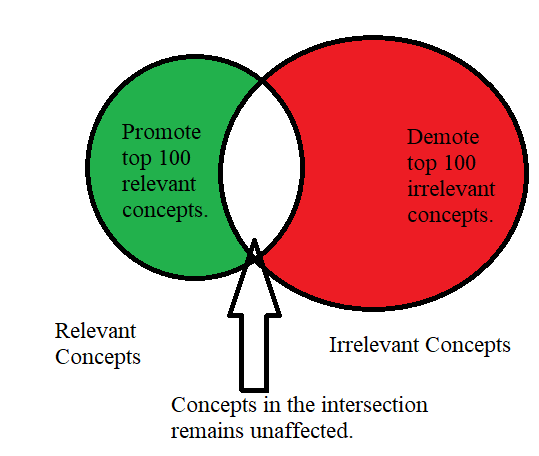

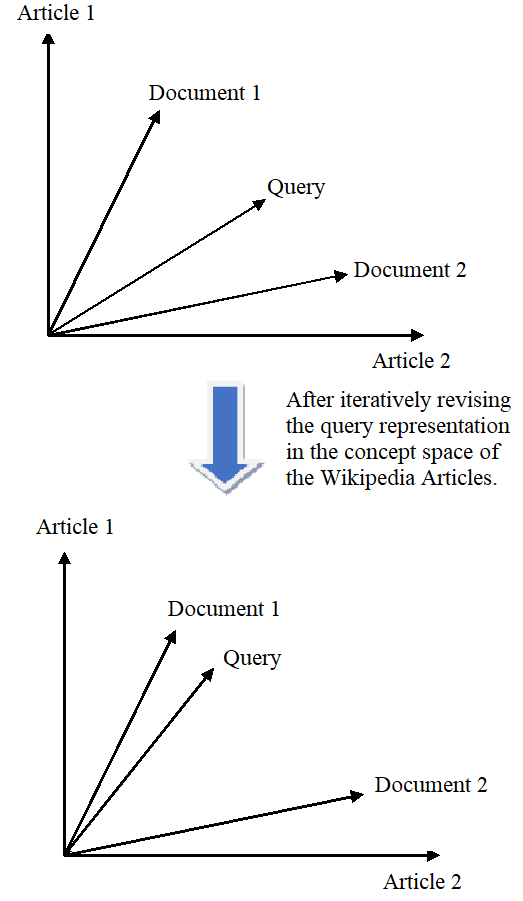

Execute cells the below two cells to see the documents after every iteration for a query.

In [ ]:
import pickle
file_to_read = open("/content/query_map_full.pickle", "rb")

query_map = pickle.load(file_to_read)

print(query_map)

{'বার্ধক্য স্বাস্থ্যে শারীরিক ও সামাজিক বিষয়গুলি': [{0: ['13121', '13042', '8125', '9157', '8389', '13026', '13103', '3117', '13098', '13033']}, {1: ['13121', '13042', '13066', '13081', '8125', '9157', '13033', '13098', '13026', '13103']}, {2: ['13121', '13042', '13066', '13081', '8125', '9157', '13098', '13033', '13026', '13103']}], 'পন্টিংয়ের ফার্স্টক্লাস ক্রিকেটের শেষ দিন': [{0: ['2454', '2185', '5093', '2494', '2213', '2097', '2426', '2471', '2402', '2500']}, {1: ['2213', '2418', '2492', '2400', '2113', '2455', '2141', '2450', '2209', '2333']}, {2: ['2213', '2450', '2492', '2141', '2113', '2455', '2400', '2403', '2333', '2209']}], 'হাঁপানি রোগের চিকিৎসা ও ওষুধ প্রয়োগ': [{0: ['13030', '13059', '13072', '13092', '13024', '13065', '13043', '13037', '13102', '13055']}, {1: ['13059', '13030', '13065', '7001', '13102', '13092', '13020', '13072', '13089', '13024']}, {2: ['13059', '13030', '13065', '13102', '13092', '13049', '13055', '13024', '7001', '13072']}], 'আর্সেনিক দূষণের কারণ ও 

In [ ]:
file_to_read = open("/content/query_set_full.pickle", "rb")

query_set = pickle.load(file_to_read)

print(query_set)

{'বার্ধক্য স্বাস্থ্যে শারীরিক ও সামাজিক বিষয়গুলি': {'8389', '13121', '8125', '9157', '13098', '13026', '13033', '13103', '13042', '13066', '13081', '3117'}, 'পন্টিংয়ের ফার্স্টক্লাস ক্রিকেটের শেষ দিন': {'2455', '2113', '2213', '2418', '2494', '2097', '2209', '2185', '2403', '2471', '2454', '2500', '2141', '2426', '2400', '2450', '2333', '5093', '2492', '2402'}, 'হাঁপানি রোগের চিকিৎসা ও ওষুধ প্রয়োগ': {'13055', '13102', '13030', '13024', '7001', '13049', '13065', '13072', '13037', '13043', '13020', '13059', '13089', '13092'}, 'আর্সেনিক দূষণের কারণ ও ফলাফল': {'13097', '13115', '13131', '13054', '13032', '5424', '13130', '13060', '12117', '13056'}, 'কোভিড-১৯ ভ্যাকসিন ও রোগ-পরবর্তী লক্ষণ': {'13001', '9025', '13024', '13069', '13008', '13072', '13108', '13044', '13104', '13058', '13043', '13006', '13132', '13035'}, 'ক্যান্সারের কারণ ও ফলাফল': {'13138', '13022', '13036', '13005', '13127', '13028', '13123', '13029', '13084', '13095'}, 'লিউকেমিয়ার ইতিহাস, লক্ষণ ও চিকিৎসা': {'13061', '13055',

Excecute the below cell to store all the documents returned by ESA in every iteration.

In [ ]:
query_map={}
query_set={}

In [ ]:
#@title Algo 6: Implicitly finding irrelevant documents.{ form-width: "20%" }
implicit_factors = np.ones(c_doc_term_matrix.shape[0])
iteration = 0
k = 10 #number of documents to be retrieved
t = 100 #number of tags in articles to be considered
alpha = 0.4 #the factor by which we increase the implicit factor
max_implicit_factor = 3
min_implicit_factor = -1
while True:
  print('ENTER THE QUERY OR EXIT BY ENTERING Q\n')
  qtext = input()
  qtexts = [qtext]
  if qtext == 'Q' or qtext == 'q':
    break
  factory = IndicNormalizerFactory()
  normalizer = factory.get_normalizer("bn", remove_nuktas=False)
  qrs = []
  for q in qtexts:
    q=normalizer.normalize(q)
    #q = bnorm(q).get('normalized')
    qrs.append(q)
  qvecs=tr_vectorizer.transform(qrs)
  Q=qvecs.toarray()
  
  q_concept_matrix = np.zeros((len(qrs),c_doc_term_matrix.shape[0]))

  q_count = 0
  # Returns a list of all the unique words in the vocabulary of Train Dataset.
  for i in range (0,len(qrs)):
    q_feature_index = qvecs [i,:].nonzero()[1]
    q_tfidf_scores = zip(q_feature_index, [qvecs [i, x] for x in q_feature_index])
    
    tfidf_vec = np.zeros((c_doc_term_matrix.shape[0]))


    # w represents the term 't'
    # s represents the tfidf score of the term 't' in document 'd'.
    for w, s in [(tr_feature_names[i], s) for (i, s) in q_tfidf_scores]:
      try:
        c_word_index = c_vectorizer.vocabulary_[w]
        # All the documents in the Concept_Dataset is considered to be a wikipedia concept.
        temp_vec = np.zeros((c_doc_term_matrix.shape[0]))
        for j in range(0,c_doc_term_matrix.shape[0]):
          temp_vec[j] =  (c_doc_term_matrix[j][c_word_index]* (max(min_implicit_factor,min(implicit_factors[j],max_implicit_factor)))) * s
          
        tfidf_vec = tfidf_vec + temp_vec
      except: 
        continue
    q_concept_matrix[i] = tfidf_vec

  newqvecs=scipy.sparse.csr_matrix(q_concept_matrix)
  newdvecs=scipy.sparse.csr_matrix(tr_doc_concept_matrix)


  A=sklearn.metrics.pairwise.cosine_similarity(newqvecs,newdvecs)
  
  
  print("ITERATION NUMBER ",iteration)
  topk_doc_ids = []
  doc_rank = {}
  for i in range(0,len(qrs)):
    x=np.argsort(A[i]).T[::-1][:k]
    j=0
    # y denotes the index number for the cosine values in A sorted in descending order.
    for y in x:
      if A[i][y]>0:
        print("# "+str(j+1)+" Doc number "+tr_dids[y]+" score "+str(round(A[i][y],2)))
        topk_doc_ids.append(tr_dids[y])
        print()
        #print(tr_docs[y])
        print("-----------")
        doc_rank[int(tr_dids[y])] = j+1
        j=j+1
    if qrs[i] in query_map:
        query_map[qrs[i]].append({iteration:topk_doc_ids})
        query_set[qrs[i]]=query_set[qrs[i]].union(set(topk_doc_ids))
    else:
        query_map[qrs[i]]=[{iteration:topk_doc_ids}]
        query_set[qrs[i]]= set()
        query_set[qrs[i]]=query_set[qrs[i]].union(set(topk_doc_ids))
  iteration += 1

  result_score = input("PRESS C TO ENTER RELEVANT DOC IDS \n PRESS Q TO QUIT \n PRESS R FOR CONTINUE\n")
  if result_score == 'C' or result_score == 'c':
    rel_doc_ids = [int(item) for item in input("Enter the relevant doc ids : ").split()]
    # Find the maximum rank of the visited document.
    last_clicked_did = -1
    for doc_id in rel_doc_ids:
      last_clicked_did = max(last_clicked_did,doc_rank[doc_id])
    unrel_doc_ids = []
    if last_clicked_did > 2:
      for did in doc_rank.keys():
        if doc_rank[did]<=last_clicked_did+1 and did not in rel_doc_ids:
          print("Document ",did," is a less likely preferred document.")
          unrel_doc_ids.append(did)
    else:
      for did in doc_rank.keys():
        if doc_rank[did]==1 and last_clicked_did==2:
          unrel_doc_ids.append(did)
          break
        elif doc_rank[did]==2 and last_clicked_did==1:
          unrel_doc_ids.append(did)
          break

    all_rel_concept_ids = {}
    for rel_doc_id in rel_doc_ids:
      rel_id = tr_dids.index(str(rel_doc_id))
      top_rel_concepts = set(tr_doc_concept_matrix[rel_id].argsort()[-t:][::-1])
      for concept_id in top_rel_concepts:
        if concept_id in all_rel_concept_ids:
          # print("Doc id: ",rel_doc_id, ", Concept id: ",concept_id,", Concept_id weight: ",all_rel_concept_ids[concept_id] + doc_rank[rel_doc_id])
          all_rel_concept_ids[concept_id] = all_rel_concept_ids[concept_id] + doc_rank[rel_doc_id]
        else:
          all_rel_concept_ids[concept_id] = doc_rank[rel_doc_id]
          # print("Doc id: ",rel_doc_id, ", Concept id: ",concept_id,", Concept_id weight: ",all_rel_concept_ids[concept_id] + doc_rank[rel_doc_id])
  

    all_dom_unrel_concepts_id = {}

    # print("\n\n\n\n")

    for unrel_doc_id in unrel_doc_ids:
      unrel_id = tr_dids.index(str(unrel_doc_id))
      top_unrel_concepts = set(tr_doc_concept_matrix[unrel_id].argsort()[-t:][::-1])
      for concept_id in top_unrel_concepts:
        if concept_id in all_dom_unrel_concepts_id:
          # print("Doc id: ",unrel_doc_id, ", Concept id: ",concept_id,", Concept_id weight: ",all_dom_unrel_concepts_id[concept_id] - doc_rank[unrel_doc_id])
          all_dom_unrel_concepts_id[concept_id] = all_dom_unrel_concepts_id[concept_id] - doc_rank[unrel_doc_id] 
        else:
          all_dom_unrel_concepts_id[concept_id] = -doc_rank[unrel_doc_id]
          # print("Doc id: ",unrel_doc_id, ", Concept id: ",concept_id,", Concept_id weight: ",all_dom_unrel_concepts_id[concept_id] - doc_rank[unrel_doc_id])

    
    unique_rel_concept_ids = list(all_rel_concept_ids.keys())

    unique_dom_unrel_concepts_id = list(all_dom_unrel_concepts_id.keys())


    dom_concept_ids = list(set(unique_rel_concept_ids) - set(unique_dom_unrel_concepts_id))
    nondom_concept_ids = list(set(unique_dom_unrel_concepts_id) - set(unique_rel_concept_ids))
    # print("Concepts that will be promoted: \n")
  
    for concept_id in dom_concept_ids:
      # print("Concept id: ",concept_id, "Score: ", pow(1.1,all_rel_concept_ids[concept_id]))
      implicit_factors[concept_id] += pow(1.1,all_rel_concept_ids[concept_id])
    # print("Concepts that will be demoted: \n")
    for concept_id in nondom_concept_ids:
      # print("Concept id: ", concept_id, "Score: ",pow(0.9,all_dom_unrel_concepts_id[concept_id]))
      implicit_factors[concept_id] -= pow(0.9,all_dom_unrel_concepts_id[concept_id])
    

  elif result_score == 'Q' or result_score == 'q':
    break
  else:
    continue



ENTER THE QUERY OR EXIT BY ENTERING Q

মদ্যপানে আসক্তি ও অ্যালকোহলের অপব্যবহার
ITERATION NUMBER  0
# 1 Doc number 13057 score 0.67

-----------
# 2 Doc number 13105 score 0.18

-----------
# 3 Doc number 4438 score 0.16

-----------
# 4 Doc number 13126 score 0.15

-----------
# 5 Doc number 12030 score 0.14

-----------
# 6 Doc number 13034 score 0.14

-----------
# 7 Doc number 13116 score 0.1

-----------
# 8 Doc number 7365 score 0.1

-----------
# 9 Doc number 7133 score 0.09

-----------
# 10 Doc number 13030 score 0.09

-----------
PRESS C TO ENTER RELEVANT DOC IDS 
 PRESS Q TO QUIT 
 PRESS R FOR CONTINUE
C
Enter the relevant doc ids : 13057 13126 12030
Document  13105  is a less likely preferred document.
Document  4438  is a less likely preferred document.
Document  13034  is a less likely preferred document.
ENTER THE QUERY OR EXIT BY ENTERING Q

মদ্যপানে আসক্তি ও অ্যালকোহলের অপব্যবহার
ITERATION NUMBER  1
# 1 Doc number 13057 score 0.68

-----------
# 2 Doc number 13105 score

In [ ]:
# save dictionary to pickle file
import pickle
with open("query_map_full.pickle", "wb") as file:
    pickle.dump(query_map, file, pickle.HIGHEST_PROTOCOL)

with open("query_set_full.pickle", "wb") as file:
    pickle.dump(query_set, file, pickle.HIGHEST_PROTOCOL)

In [ ]:
for key in query_map.keys():
  print(key,*query_map[key],sep="\n")

বার্ধক্য স্বাস্থ্যে শারীরিক ও সামাজিক বিষয়গুলি
{0: ['13121', '13042', '8125', '9157', '8389', '13026', '13103', '3117', '13098', '13033']}
{1: ['13121', '13042', '13066', '13081', '8125', '9157', '13033', '13098', '13026', '13103']}
{2: ['13121', '13042', '13066', '13081', '8125', '9157', '13098', '13033', '13026', '13103']}
পন্টিংয়ের ফার্স্টক্লাস ক্রিকেটের শেষ দিন
{0: ['2454', '2185', '5093', '2494', '2213', '2097', '2426', '2471', '2402', '2500']}
{1: ['2213', '2418', '2492', '2400', '2113', '2455', '2141', '2450', '2209', '2333']}
{2: ['2213', '2450', '2492', '2141', '2113', '2455', '2400', '2403', '2333', '2209']}
হাঁপানি রোগের চিকিৎসা ও ওষুধ প্রয়োগ
{0: ['13030', '13059', '13072', '13092', '13024', '13065', '13043', '13037', '13102', '13055']}
{1: ['13059', '13030', '13065', '7001', '13102', '13092', '13020', '13072', '13089', '13024']}
{2: ['13059', '13030', '13065', '13102', '13092', '13049', '13055', '13024', '7001', '13072']}
আর্সেনিক দূষণের কারণ ও ফলাফল
{0: ['13097', '13032

In [ ]:
print(query_set)

{'বার্ধক্য স্বাস্থ্যে শারীরিক ও সামাজিক বিষয়গুলি': {'13098', '13042', '13033', '13066', '3117', '8389', '13103', '13121', '13026', '8125', '9157', '13081'}, 'পন্টিংয়ের ফার্স্টক্লাস ক্রিকেটের শেষ দিন': {'2403', '2492', '2455', '2402', '2500', '2454', '2097', '2113', '2400', '2213', '2418', '2450', '2141', '2471', '5093', '2185', '2494', '2426', '2333', '2209'}, 'হাঁপানি রোগের চিকিৎসা ও ওষুধ প্রয়োগ': {'13092', '13043', '13030', '13065', '13059', '13072', '13024', '13089', '13020', '7001', '13055', '13102', '13049', '13037'}, 'আর্সেনিক দূষণের কারণ ও ফলাফল': {'13060', '13115', '13097', '13131', '13054', '12117', '13056', '13130', '13032', '5424'}, 'কোভিড-১৯ ভ্যাকসিন ও রোগ-পরবর্তী লক্ষণ': {'13043', '13132', '13108', '13058', '13104', '13006', '13072', '9025', '13024', '13069', '13044', '13001', '13008', '13035'}, 'ক্যান্সারের কারণ ও ফলাফল': {'13123', '13028', '13084', '13022', '13029', '13005', '13095', '13127', '13138', '13036'}, 'লিউকেমিয়ার ইতিহাস, লক্ষণ ও চিকিৎসা': {'13092', '13043',